This notebook demonstrates some Machine Learning and data analysis techniques which can be carried out using PySpark on ALCF's Theta or Cooley cluster.
The original kernel was developed for the PLAsTiCC challenge on Kaggle and has been adapted to use pySpark.

*Elise Jennings (ejennings@anl.gov)*

Required Python packages:
- numpy
- sklearn
- seaborn
- astropy
- cesium

In [1]:
%matplotlib inline

import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

/home/elise/.local/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array



# Datasets

The data for this notebook is available at https://www.kaggle.com/c/PLAsTiCC-2018/data together with a description of each file. The dataset  is split into a light curve table and a metadata table. 


Below we split up the smaller training set (7848 samples) and featurize, carry out a PCA and apply a random forest classifier.
Ideally we would train on all of the training set and then test using larger test set (3.49M samples). Below the training set is split for training and testing for demonstrations purposes.

We describe a mapping from string passband name to integer passband IDs. Here, we'll create an OrderedDict to invert that transformation.

In [2]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [3]:
metafilename = '/projects/datascience/elise/PLAsTiCC_data/training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)

In [4]:
test_metafilename = '/projects/datascience/elise/PLAsTiCC_data/test_set_metadata.csv'
test_metadata = Table.read(test_metafilename, format='csv')
test_nobjects = len(test_metadata)

In [4]:
lcfilename = '/projects/datascience/elise/PLAsTiCC_data/training_set.csv'
lcdata = Table.read(lcfilename, format='csv')
type(metadata)

astropy.table.table.Table

In [5]:
#Create Cesium timeseries for each sample

def create_timeseries(row):
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    ts = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    return thisid,ts


 # Create a rdd

In [6]:
rdd = sc.parallelize(metadata)


In [7]:
result=rdd.map(create_timeseries)

In [8]:
tsdict = OrderedDict()

runresult = result.collect()

for r in runresult:
    tsdict[r[0]] = r[1]
    

# Find features
For each time series find certain features using Cesium

In [9]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [10]:
def find_features(tsobj):
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [11]:
rdd_2 = sc.parallelize(tsdict.values())

In [12]:
result_2=rdd_2.map(find_features)

In [17]:
featurefile = 'plasticc_featuretable.npz'

if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    results_2 = result_2.collect()
 
    featuretable = featurize.assemble_featureset(features_list=results_2,\
                                  time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

# Feature Table

The computed feature table has descriptive statistics for each object which are a low-dimensional encoding of the information in the light curves. We need to process this into a simple table and split into training and testing data sets.

In [18]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

In [19]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

In [20]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [21]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

# PCA
Carry out PCA on the features

In [22]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

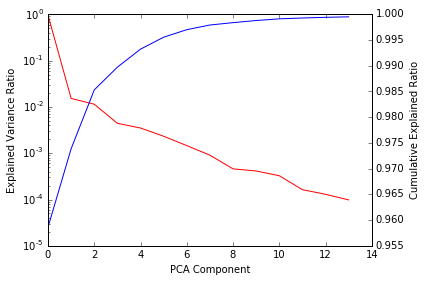

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='r')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='b')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

# Random Forest classifier
We'll use a random forest here, but we can try other classifiers.

In [24]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')

In [25]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


In [26]:
counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

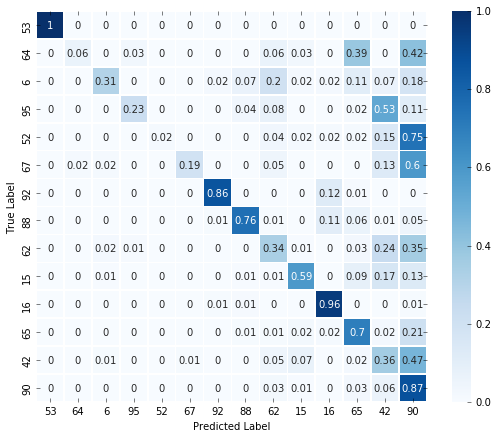

In [27]:

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')